# Description
In this notebook, I will implement data cleaning, feature engineering, and handling imbalance dataset experiment with various tree-based model architecture mainly from sklearn library.
Based model shall be establish before experimenting with other model.
I will also try on ensemble method and lastly tuning the best hyperparameters.

Multiple experiment and data processing can be done using the function data_preprocessing.

#### Handle Missing Values:
 * Replace with mean value: ['Date Of Birth'] column which just have 8 missings.
 * Impute with mode for categorical features
 * KNN imputation for numerical features

#### Handle Outliers:
 * Remove outliers using z-score with threshold = 3 for numerical features.

 #### Handle Imbalance Dataset:
 * Using SMOTE for upsampling dataset
 * USING RUS or NearMiss for undersampling dataset

 ### Feature Engineering
 * Create Age column which is the difference between Leading Creation Date - Birth Date
 * Create debt to income ratio
 * create_monthly_loan_repayment_column
 * create_payment_to_income_ratio_column
 * create_loan_to_income_ratio_column
 

In [23]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
def open_csv_as_dataframe(file_path:str) -> pd.DataFrame:
    """
    Opens a CSV file as a DataFrame.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pandas.DataFrame: The DataFrame containing the CSV data.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print("Error: File not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [25]:
# Rename the columns for easier access
rename = {
         '02': 'Gender', '03': 'Date Of Birth',
         '04': 'Lead Creation Date','05': 'City Code',
         '06': 'Area Code','07': 'Employer Code',
         '08': 'Employer Category1','09': 'Employer Category2',
         '10': 'Monthly Income','11': 'Bank Code',
         '12': 'Bank Account Type','13': 'Marketing Source',
         '14': 'Marketing Category1','15': 'Marketing Category2',
         '16': 'Current Loan Installment','17': 'Requested Loan Amount',
         '18': 'Loan Repayment (Years)','19': 'Interest Rate',
         '20': 'Requested Loan Installment'
         }

In [26]:
def summary_df(df:pd.DataFrame) -> pd.DataFrame:
    """
    Generates a summary of the DataFrame including data types, counts, unique values,
    percentages of unique values, null counts, percentages of null values, and basic 
    statistics for numeric columns.

    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.

    Returns:
    pd.DataFrame: Summary DataFrame.
    """
    df_copy = df.copy()
    
    # Initialize an empty DataFrame to store summary information
    desc = pd.DataFrame(index=list(df_copy))

    desc['type'] = df_copy.dtypes
    desc['count'] = df_copy.count()
    desc['nunique'] = df_copy.nunique()
    desc['%unique'] = desc['nunique'] / len(df_copy) * 100
    desc['null'] = df_copy.isnull().sum()
    desc['%null'] = desc['null'] / len(df_copy) * 100
    
    # Concatenate summary statistics for numeric columns
    desc = pd.concat([desc, df_copy.describe().T.drop('count', axis=1)], axis=1)
    desc = desc.sort_values(by=['type', 'null'])
    
    return desc

In [27]:
# create age column (age during loan application), for age invalid age(negative value), change the value to median
def create_age_column(df:pd.DataFrame) -> pd.DataFrame:
    """
    Creates a new column 'Age' from the 'Date Of Birth' and 'Lead Creation Date' columns.
    Change any age < 0 to median
    
    Parameters:
        df (DataFrame): Input DataFrame.
    
    Returns:
        DataFrame: DataFrame with age column.
    """
    df_copy = df.copy()
    
    df_copy['Date Of Birth'] = pd.to_datetime(df_copy['Date Of Birth'])
    df_copy['Lead Creation Date'] = pd.to_datetime(df_copy['Lead Creation Date'])
    df_copy['Age'] = (df_copy['Lead Creation Date'] - df_copy['Date Of Birth']).dt.days // 365

    # Calculate the mean of the 'age' column, excluding negative values
    # mean_age = df_copy[df_copy['Age'] >= 0]['Age'].mean()
    # df_copy.loc[df_copy['Age'] < 0, 'Age'] = mean_age
    df_copy.loc[df_copy['Age'] < 0, 'Age'] = None

    return df_copy

In [28]:
def create_debt_to_income_ratio_column(df:pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column indicating the debt to income ratio, adding a small value if the ratio is 0.
    
    Parameters:
        df (DataFrame): Input DataFrame containing 'Current Loan Installment' and 'Monthly Income' columns.
        small_value (float): Small value to add if the debt to income ratio is 0. Default is 1e-9.
    
    Returns:
        DataFrame: DataFrame with the new 'Debt To Income Ratio' column.
    """
    df_copy = df.copy()
    df_copy['Debt To Income Ratio'] = df_copy['Current Loan Installment'] / df_copy['Monthly Income']
    df_copy['Debt To Income Ratio'] = df_copy['Debt To Income Ratio'].apply(lambda x: x if x > 0 else 0)
    return df_copy

In [29]:
def create_monthly_loan_repayment_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column indicating the monthly loan repayment amount.
    
    Parameters:
        df (DataFrame): Input DataFrame containing 'Requested Loan Amount', 'Interest Rate', and 'Loan Repayment (Years)' columns.
    
    Returns:
        DataFrame: DataFrame with the new 'Monthly Loan Repayment' column.
    """
    df_copy = df.copy()
    
    # Calculate monthly interest rate
    df_copy['Monthly Interest Rate'] = df_copy['Interest Rate'] / 12 / 100
    
    # Convert years to total number of payments (months)
    df_copy['Total Repayments Month'] = df_copy['Loan Repayment Years'] * 12
    
    # Calculate the monthly loan repayment amount using the formula (EMI)
    numerator = df_copy['Requested Loan Amount'] * df_copy['Monthly Interest Rate'] * (1 + df_copy['Monthly Interest Rate'])**df_copy['Total Repayments Month']
    denominator = ((1 + df_copy['Monthly Interest Rate'])**df_copy['Total Repayments Month']) - 1
    df_copy['Monthly Loan Repayment Amount'] = numerator / denominator

    #drop unnessary columns
    df_copy = df_copy.drop(['Total Repayments Month', 'Monthly Interest Rate'], axis=1)

    return df_copy


In [30]:
def create_payment_to_income_ratio_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identify if applicants have enough balance to pay for the applied loan.
    
    Parameters:
        df (DataFrame): Input DataFrame containing 'Monthly Income', 'Current Monthly Loan Installment', 
                        'Requested Loan Amount', 'Interest Rate', and 'Loan Repayment (Years)' columns.
    
    Returns:
        DataFrame: DataFrame with a new column 'Can Afford Loan' indicating whether applicants have enough balance to pay for the applied loan.
    """
    df_copy = df.copy()

    #Calculate Payment-to-income-ratio
    df_copy['Payment to Income Ratio'] = df_copy.apply(lambda row:
        (row['Monthly Loan Repayment Amount'] + row['Current Loan Installment']) / row['Monthly Income'] 
        if row['Monthly Income'] > 0 else 0,
        axis=1
    )

    return df_copy

In [31]:
def create_loan_to_income_ratio_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column indicating the loan to income ratio, handling cases where monthly income is zero.

    Parameters:
        df (DataFrame): Input DataFrame containing 'Monthly Loan Repayment Amount' and 'Monthly Income' columns.

    Returns:
        DataFrame: DataFrame with the new 'Loan To Income Ratio' column.
    """
    df_copy = df.copy()
    df_copy['Loan To Income Ratio'] = df_copy.apply(lambda row: 
        row['Monthly Loan Repayment Amount'] / row['Monthly Income'] if row['Monthly Income'] > 0 else 0,
        axis=1
    )
    return df_copy

In [32]:
def drop_column (df:pd.DataFrame, columns:list[str]) -> pd.DataFrame:
    """
    Drop multiple colums simultaniously.
    
    Parameters:
        df (DataFrame): Input DataFrame.
        columns (list): List of column names to drop.
    
    Returns:
        DataFrame: DataFrame with dropped column.
    """
     
    for col in columns:
         df = df.drop([col], axis=1)
    return df

# Data Imputation for Missing Values

There are a lot of missing values. I can not remove any of them since the minority class is really low.

- **Categorical:** I will use the mode to impute missing categorical data
- **Numerical:** We use the median to impute missing numerical data since majority of the features is skew.

In [33]:
from sklearn.impute import SimpleImputer


def simple_impute(df:pd.DataFrame, columns:list[str], strategy:str) -> pd.DataFrame:
    """
    Impute missing values in using SimpleImputer on mulitple columns
    
    Parameters:
        df (DataFrame): Input DataFrame.
        columns_to_impute (list): List of column names to impute missing values.
        strategy: typicall value 'mean', 'median', 'most-frequent', 'constant'
    
    Returns:
        DataFrame: DataFrame with imputed values.
    """
    df_impute = df.copy()

    # Impute missing values with the mean of the respective columns
    imputer = SimpleImputer(strategy=strategy) # I use median because data is skewed
    for column in columns:
        df_impute[column] = imputer.fit_transform(df_impute[[column]])

    print(df_impute.isnull().sum())

    return df_impute

In [34]:
# impute missing data using KNN
from sklearn.impute import KNNImputer

def knn_impute(df:pd.DataFrame, columns_to_impute:list[str], n_neighbors:int=5) -> pd.DataFrame:
    """
    Impute missing values in selective columns using KNN imputation for numerical features.
    
    Parameters:
        df (DataFrame): Input DataFrame.
        columns_to_impute (list): List of column names to impute missing values.
        n_neighbors (int): Number of neighbors for KNN imputation.
    
    Returns:
        DataFrame: DataFrame with imputed values.
    """
    df_impute = df.copy()

    # Initialize KNN imputer with the desired number of neighbors
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Perform KNN imputation on selective columns only
    df_impute[columns_to_impute] = knn_imputer.fit_transform(df_impute[columns_to_impute])

    print(df_impute.isnull().sum())

    return df_impute


# Data Visualization

In [35]:
def plot_boxplots(df:pd.DataFrame, columns:list[str], num_cols_per_row:int=2):
    """
    Plot boxplots for numerical columns in the DataFrame.

    Parameters:
        df_train (pd.DataFrame): DataFrame containing the training data.
        NUM_COLS (list): List of numerical column names.
        num_cols_per_row (int): Number of boxplots per row in the subplot grid. Default is 2.

    Returns:
        None
    """
    # Calculate the number of rows needed based on the number of numerical columns and the desired number of boxplots per row
    num_rows = (len(columns) + num_cols_per_row - 1) // num_cols_per_row

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(10, 5*num_rows))  # Adjust figure size as needed

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical feature and plot its boxplot on a separate axis
    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [36]:
def plot_histograms(df:pd.DataFrame, columns:list[str], bins:int=30, figsize=(30, 30)) -> None:
    """
    Plot histograms for numerical columns in the DataFrame.

    Parameters:
        df_train (pd.DataFrame): DataFrame containing the training data.
        NUM_COLS (list): List of numerical column names.
        bins (int): Number of bins for the histograms. Default is 30.
        figsize (tuple): Figure size of the plot. Default is (30, 30).

    Returns:
        None
    """
    df[columns].hist(bins=bins, figsize=figsize)
    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()


# Data Correlation

NOTE:
1. Correlation heatmap only applicable for numerical features.
2. For categorical features, I need to convert to numerical first using method like one-hot encoding or label encoding. But since the original data already converted to numerical, I can plot every features.

In [37]:
#Correlation Matrix Heatmap for all data type since categorical has been converted to numerical by default
def correlation_heatmap(df:pd.DataFrame):
    """
    Plots a heatmap of the correlation matrix of the dataset.

    Parameters:
    - df: pandas DataFrame

    Returns:
    None
    """
    plt.figure(figsize=(15, 10))
    sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# Data Scaling

Execute Normalizationa and Standardization for numerica features only.

Normalization: Normalization (also known as min-max scaling) scales features to a range between 0 and 1. Use normalization when the distribution of your features doesn't follow a normal distribution, and you want to preserve the relative relationships between values.

Standardization: Standardization (z-score scaling) scales features to have a mean of 0 and a standard deviation of 1. Use standardization when the distribution of your features is approximately normal or when you're using algorithms that assume normally distributed data.

RobustScalar: is a preprocessing technique used in machine learning to scale features of a dataset. It is robust to outliers, meaning it scales the data based on statistics that are robust to outliers rather than the mean and standard deviation. This makes it suitable for datasets that contain outliers or have a non-Gaussian distribution.

In [38]:
from sklearn.preprocessing import StandardScaler

def standardization_scaling(df: pd.DataFrame, columns: list):
    """
    Normalizes continuous variables in a DataFrame using StandardScaler.

    Parameters:
    - df: pandas DataFrame
        Input DataFrame containing the columns to be normalized.
    - columns: list of strings
        List of column names to be normalized.

    Returns:
    - df: pandas DataFrame
        DataFrame with specified columns normalized.
    """
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    scaler = StandardScaler()

    # Iterate over each column and apply StandardScaler
    for col in columns:
        # Ensure the column is numeric (it should be, but just to be safe)
        if df_copy[col].dtype in ['int64', 'float64']:
            df_copy[col] = scaler.fit_transform(df_copy[[col]])
    return df_copy

In [39]:
from sklearn.preprocessing import MinMaxScaler

def normalization_scaling(df:pd.DataFrame, columns:list):
    """
    Normalizes continuous variables in a DataFrame using MinMaxScaler.

    Parameters:
    - df: pandas DataFrame
        Input DataFrame containing the columns to be normalized.
    - columns: list of strings
        List of column names to be normalized.

    Returns:
    - df: pandas DataFrame
        DataFrame with specified columns normalized.
    """
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    scaler = MinMaxScaler()
    for col in columns:
        # Ensure the column is numeric (it should be, but just to be safe)
        if df_copy[col].dtype in ['int64', 'float64']:
            df_copy[col] = scaler.fit_transform(df_copy[[col]])
    return df_copy


In [40]:
from sklearn.preprocessing import RobustScaler

def robust_scaling(df:pd.DataFrame, columns:list):
    """
    Normalizes continuous variables in a DataFrame using RobustScaler.

    Parameters:
    - df: pandas DataFrame
        Input DataFrame containing the columns to be robust scaled.
    - columns: list of strings
        List of column names to be robust scaled.

    Returns:
    - df: pandas DataFrame
        DataFrame with specified columns robust scaled.
    """
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    scaler = RobustScaler()
    for col in columns:
        df_copy[col] = scaler.fit_transform(df_copy[col].values.reshape(-1,1))
    return df_copy

### Handling Outliers

NOTE: Only applicable for numerical features. For categorical features, since the data is discrete and don't represent a numerical scale, even after coverting with labelencoder, we do not need to remove the outliers.

In [41]:
def remove_outliers_iqr(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Remove outliers from a DataFrame using the Interquartile Range (IQR) method.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to consider for outlier removal.

    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """
    df_cleaned = df.copy()
    
    # Loop through each column
    for col in columns:
        # Calculate the first quartile (Q1)
        Q1 = df_cleaned[col].quantile(0.25)
        # Calculate the third quartile (Q3)
        Q3 = df_cleaned[col].quantile(0.75)
        # Calculate the interquartile range (IQR)
        IQR = Q3 - Q1
        # Define the upper and lower bounds for outlier detection
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter out rows that fall within the bounds
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    
    return df_cleaned


In [42]:
from scipy import stats

def remove_outliers_zscore(df:pd.DataFrame, columns:list[str], threshold:int=3) -> pd.DataFrame:
    """
    Remove outliers from multiple columns using z-scores.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to consider for outlier removal.
        threshold (float): Threshold for z-score. Observations with z-scores higher than this threshold are considered outliers. Default is 3 standard deviation.

    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """
    # Validate input columns
    invalid_cols = [col for col in columns if col not in df.columns]
    if invalid_cols:
        raise ValueError(f"Invalid columns: {', '.join(invalid_cols)}")
    
    df_cleaned = df.copy()

    # Calculate z-scores for specified columns
    z_scores = np.abs(stats.zscore(df_cleaned[columns]))

    # Find and remove rows with z-scores higher than the threshold
    outlier_mask = (z_scores < threshold).all(axis=1)
    df_cleaned = df_cleaned[outlier_mask]

    return df_cleaned

## Data Preprocessing-Function

In [43]:
def data_preprocessing(file_path:str, is_submission:bool=False) -> pd.DataFrame:
    """
    Creates the data processing procedure for training dataset

    Parameters:
        df: trained dataframe

    Returns:
       df: cleaned dataframe
    """
    rename = {
        '02': 'Gender', '03': 'Date Of Birth',
        '04': 'Lead Creation Date','05': 'City Code',
        '06': 'Area Code','07': 'Employer Code',
        '08': 'Employer Category1','09': 'Employer Category2',
        '10': 'Monthly Income','11': 'Bank Code',
        '12': 'Bank Account Type','13': 'Marketing Source',
        '14': 'Marketing Category1','15': 'Marketing Category2',
        '16': 'Current Loan Installment','17': 'Requested Loan Amount',
        '18': 'Loan Repayment Years','19': 'Interest Rate',
        '20': 'Requested Loan Installment'
        }
    
    NUM_COLS = ['Monthly Income', 'Bank Code', 'Current Loan Installment', 'Requested Loan Amount', 'Loan Repayment Years', 'Interest Rate', 'Requested Loan Installment']
    CAT_COLS = ['Gender', 'City Code', 'Area Code', 'Employer Code', 'Employer Category1', 'Employer Category2', 'Bank Account Type', 'Marketing Source', 'Marketing Category1', 'Marketing Category2']

    df = open_csv_as_dataframe(file_path)
    df_clean = df.copy()
    df_clean = df_clean.rename(columns=rename)

    # ## -------- DATA CLEANING -----------##
    df_clean = drop_column(df_clean, ['id']) # drop id column to avoid confusion in imputation
    
    # ## -------- DATA IMPUTATION -----------##
    # IMPUTE CATEGORICAL TYPE
    # Since the data given already converted as numerical, i will treat the features like numerical. Impute the data with most_frequent might skwed the data.
    IMPUTE_CAT_COLUMN = ['Area Code', 'Employer Category1', 'Employer Category2', 'Bank Account Type']
    df_clean = knn_impute(df_clean, IMPUTE_CAT_COLUMN)
    df_clean[IMPUTE_CAT_COLUMN] = df_clean[IMPUTE_CAT_COLUMN].round().astype(int) # to avoid default KNN impute as float value.

    # # # # NUMERICAL data will be imputed with the KNN Imputation
    df_clean = simple_impute(df_clean, ['Current Loan Installment', 'Requested Loan Installment'], strategy='median') # since just 41 missing values
    # df_clean = knn_impute(df_clean, ['Current Loan Installment', 'Requested Loan Installment']) # since just 41 missing values

    # df_clean = knn_impute(df_clean, ['Requested Loan Amount', 'Loan Repayment (Years)', 'Interest Rate']) # Critical missing values of 40-68%
    # df_clean['Loan Repayment (Years)'] = df_clean['Loan Repayment (Years)'].round().astype(int)

    # for inference on kagel submission, I dont want the outliers to be removed from the dataset
    # if not is_submission:
    # # #     # ## -------- HANDLING OUTLIERS-----------##

    # # #     # OUTLIER_COLS_IQR = ['Monthly Income'] # maybe can try remove outliers for monthly income using IQR
    # # #     # df_clean = remove_outliers_iqr(df_clean, OUTLIER_COLS_IQR)

    #     # OUTLIER_COLS_Z = ['Monthly Income', 'Current Loan Installment', 'Requested Loan Amount'] #critical outliers
    #     OUTLIER_COLS_Z = ['Monthly Income', 'Current Loan Installment'] #critical outliers
    #     df_clean = remove_outliers_zscore(df_clean, OUTLIER_COLS_Z, threshold=3)
        
    # #     # manual cleaning
    # #     df_clean = df_clean[df_clean['Debt To Income Ratio'] <= 5.00]

    ## -------- FEATURE ENGINEERING -----------##
    df_clean = create_age_column(df_clean)
    mean_age = df_clean[df_clean['Age'] >= 0]['Age'].mean()
    df_clean.loc[df_clean['Age'] < 0, 'Age'] = mean_age
    df_clean = simple_impute(df_clean, ['Age'], strategy='mean')

    df_clean = create_debt_to_income_ratio_column(df_clean)
    df_clean = create_monthly_loan_repayment_column(df_clean)
    df_clean = create_loan_to_income_ratio_column (df_clean)
    df_clean = create_payment_to_income_ratio_column(df_clean)
        
    # ## -------- DATA SCALING -----------##
    columns_to_standardize = ['Age']
    df_clean = standardization_scaling(df_clean, columns_to_standardize)

    df_clean = normalization_scaling(df_clean, CAT_COLS)

    columns_to_log = ['Monthly Income', 'Current Loan Installment', 'Requested Loan Amount', 'Requested Loan Installment', 'Debt To Income Ratio', 'Monthly Loan Repayment Amount', 'Loan To Income Ratio', 'Payment to Income Ratio']
    for col in columns_to_log:
        df_clean[col] = np.log1p(df_clean[col])
    
    columns_to_normalize = ['Interest Rate', 'Bank Code', 'Loan Repayment Years']
    df_clean = normalization_scaling(df_clean, columns_to_normalize)

    DROP_COL = ['Date Of Birth', 'Lead Creation Date', 'Bank Code']
    df_clean = drop_column(df_clean, DROP_COL)

    DROP_COL2 = ['Requested Loan Amount','Loan Repayment Years', 'Monthly Loan Repayment Amount', 'Loan To Income Ratio', 'Payment to Income Ratio', 'Interest Rate']
    df_clean = drop_column(df_clean, DROP_COL2)

    # # Specify NUMERICAL columns to be robust scale
    # columns_to_robust_scale = ['Loan To Income Ratio', 'Payment to Income Ratio', 'Interest Rate']
    # df_clean = robust_scaling(df_clean, columns_to_robust_scale)

    return df_clean


In [44]:
df_train = data_preprocessing('../data/train.csv', is_submission=False)

Gender                            0
Date Of Birth                     8
Lead Creation Date                0
City Code                         0
Area Code                         0
Employer Code                     0
Employer Category1                0
Employer Category2                0
Monthly Income                    0
Bank Code                         0
Bank Account Type                 0
Marketing Source                  0
Marketing Category1               0
Marketing Category2               0
Current Loan Installment         41
Requested Loan Amount         22131
Loan Repayment Years          22131
Interest Rate                 37941
Requested Loan Installment       41
class                             0
dtype: int64
Gender                            0
Date Of Birth                     8
Lead Creation Date                0
City Code                         0
Area Code                         0
Employer Code                     0
Employer Category1                0
Employer Catego

In [45]:
desc_train = summary_df(df_train)
desc_train.style.background_gradient()

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
class,int64,55760,2,0.003587,0,0.000000,0.015136,0.122096,0.000000,0.000000,0.000000,0.000000,1.000000
Gender,float64,55760,2,0.003587,0,0.000000,0.572956,0.494653,0.000000,0.000000,1.000000,1.000000,1.000000
City Code,float64,55760,656,1.176471,0,0.000000,0.506632,0.222829,0.000000,0.249671,0.535656,0.689821,1.000000
Area Code,float64,55760,3,0.005380,0,0.000000,0.222041,0.382196,0.000000,0.000000,0.000000,0.500000,1.000000
Employer Code,float64,55760,30756,55.157819,0,0.000000,0.500216,0.279996,0.000000,0.269364,0.499929,0.737436,1.000000
Employer Category1,float64,55760,3,0.005380,0,0.000000,0.359505,0.391100,0.000000,0.000000,0.500000,0.500000,1.000000
Employer Category2,float64,55760,4,0.007174,0,0.000000,0.907000,0.262657,0.000000,1.000000,1.000000,1.000000,1.000000
Monthly Income,float64,55760,4308,7.725968,0,0.000000,7.896447,0.913039,0.000000,7.457898,7.873217,8.343078,17.511937
Bank Account Type,float64,55760,2,0.003587,0,0.000000,0.330721,0.470477,0.000000,0.000000,0.000000,1.000000,1.000000
Marketing Source,float64,55760,28,0.050215,0,0.000000,0.078655,0.104481,0.000000,0.000000,0.074074,0.111111,1.000000


In [46]:
df_train['class'].value_counts()

class
0    54916
1      844
Name: count, dtype: int64

In [47]:
df_train.duplicated().sum()

2600

In [48]:
df_train.head()

,Gender,City Code,Area Code,Employer Code,Employer Category1,Employer Category2,Monthly Income,Bank Account Type,Marketing Source,Marketing Category1,Marketing Category2,Current Loan Installment,Requested Loan Installment,class,Age,Debt To Income Ratio
0,0.0,0.729447,0.0,0.795508,0.5,1.000000,7.789869,1.0,0.148148,0.333333,0.4,0.000000,0.000000,0,-1.264406,0.000000
1,1.0,0.162779,1.0,0.499929,0.5,0.666667,7.873217,1.0,0.000000,1.000000,0.0,0.000000,0.000000,0,2.396840,0.000000
2,1.0,0.729447,0.0,0.931438,0.5,1.000000,8.820773,0.0,0.111111,0.166667,1.0,7.632421,7.632421,0,0.889268,0.265912
3,0.0,0.535656,0.0,0.211375,0.0,0.666667,8.984819,0.0,0.111111,0.166667,1.0,7.362645,7.362645,0,2.612208,0.180126
4,0.0,0.729447,0.0,0.447107,0.5,1.000000,6.852243,0.0,0.111111,0.333333,0.0,0.000000,0.000000,0,-1.479773,0.000000


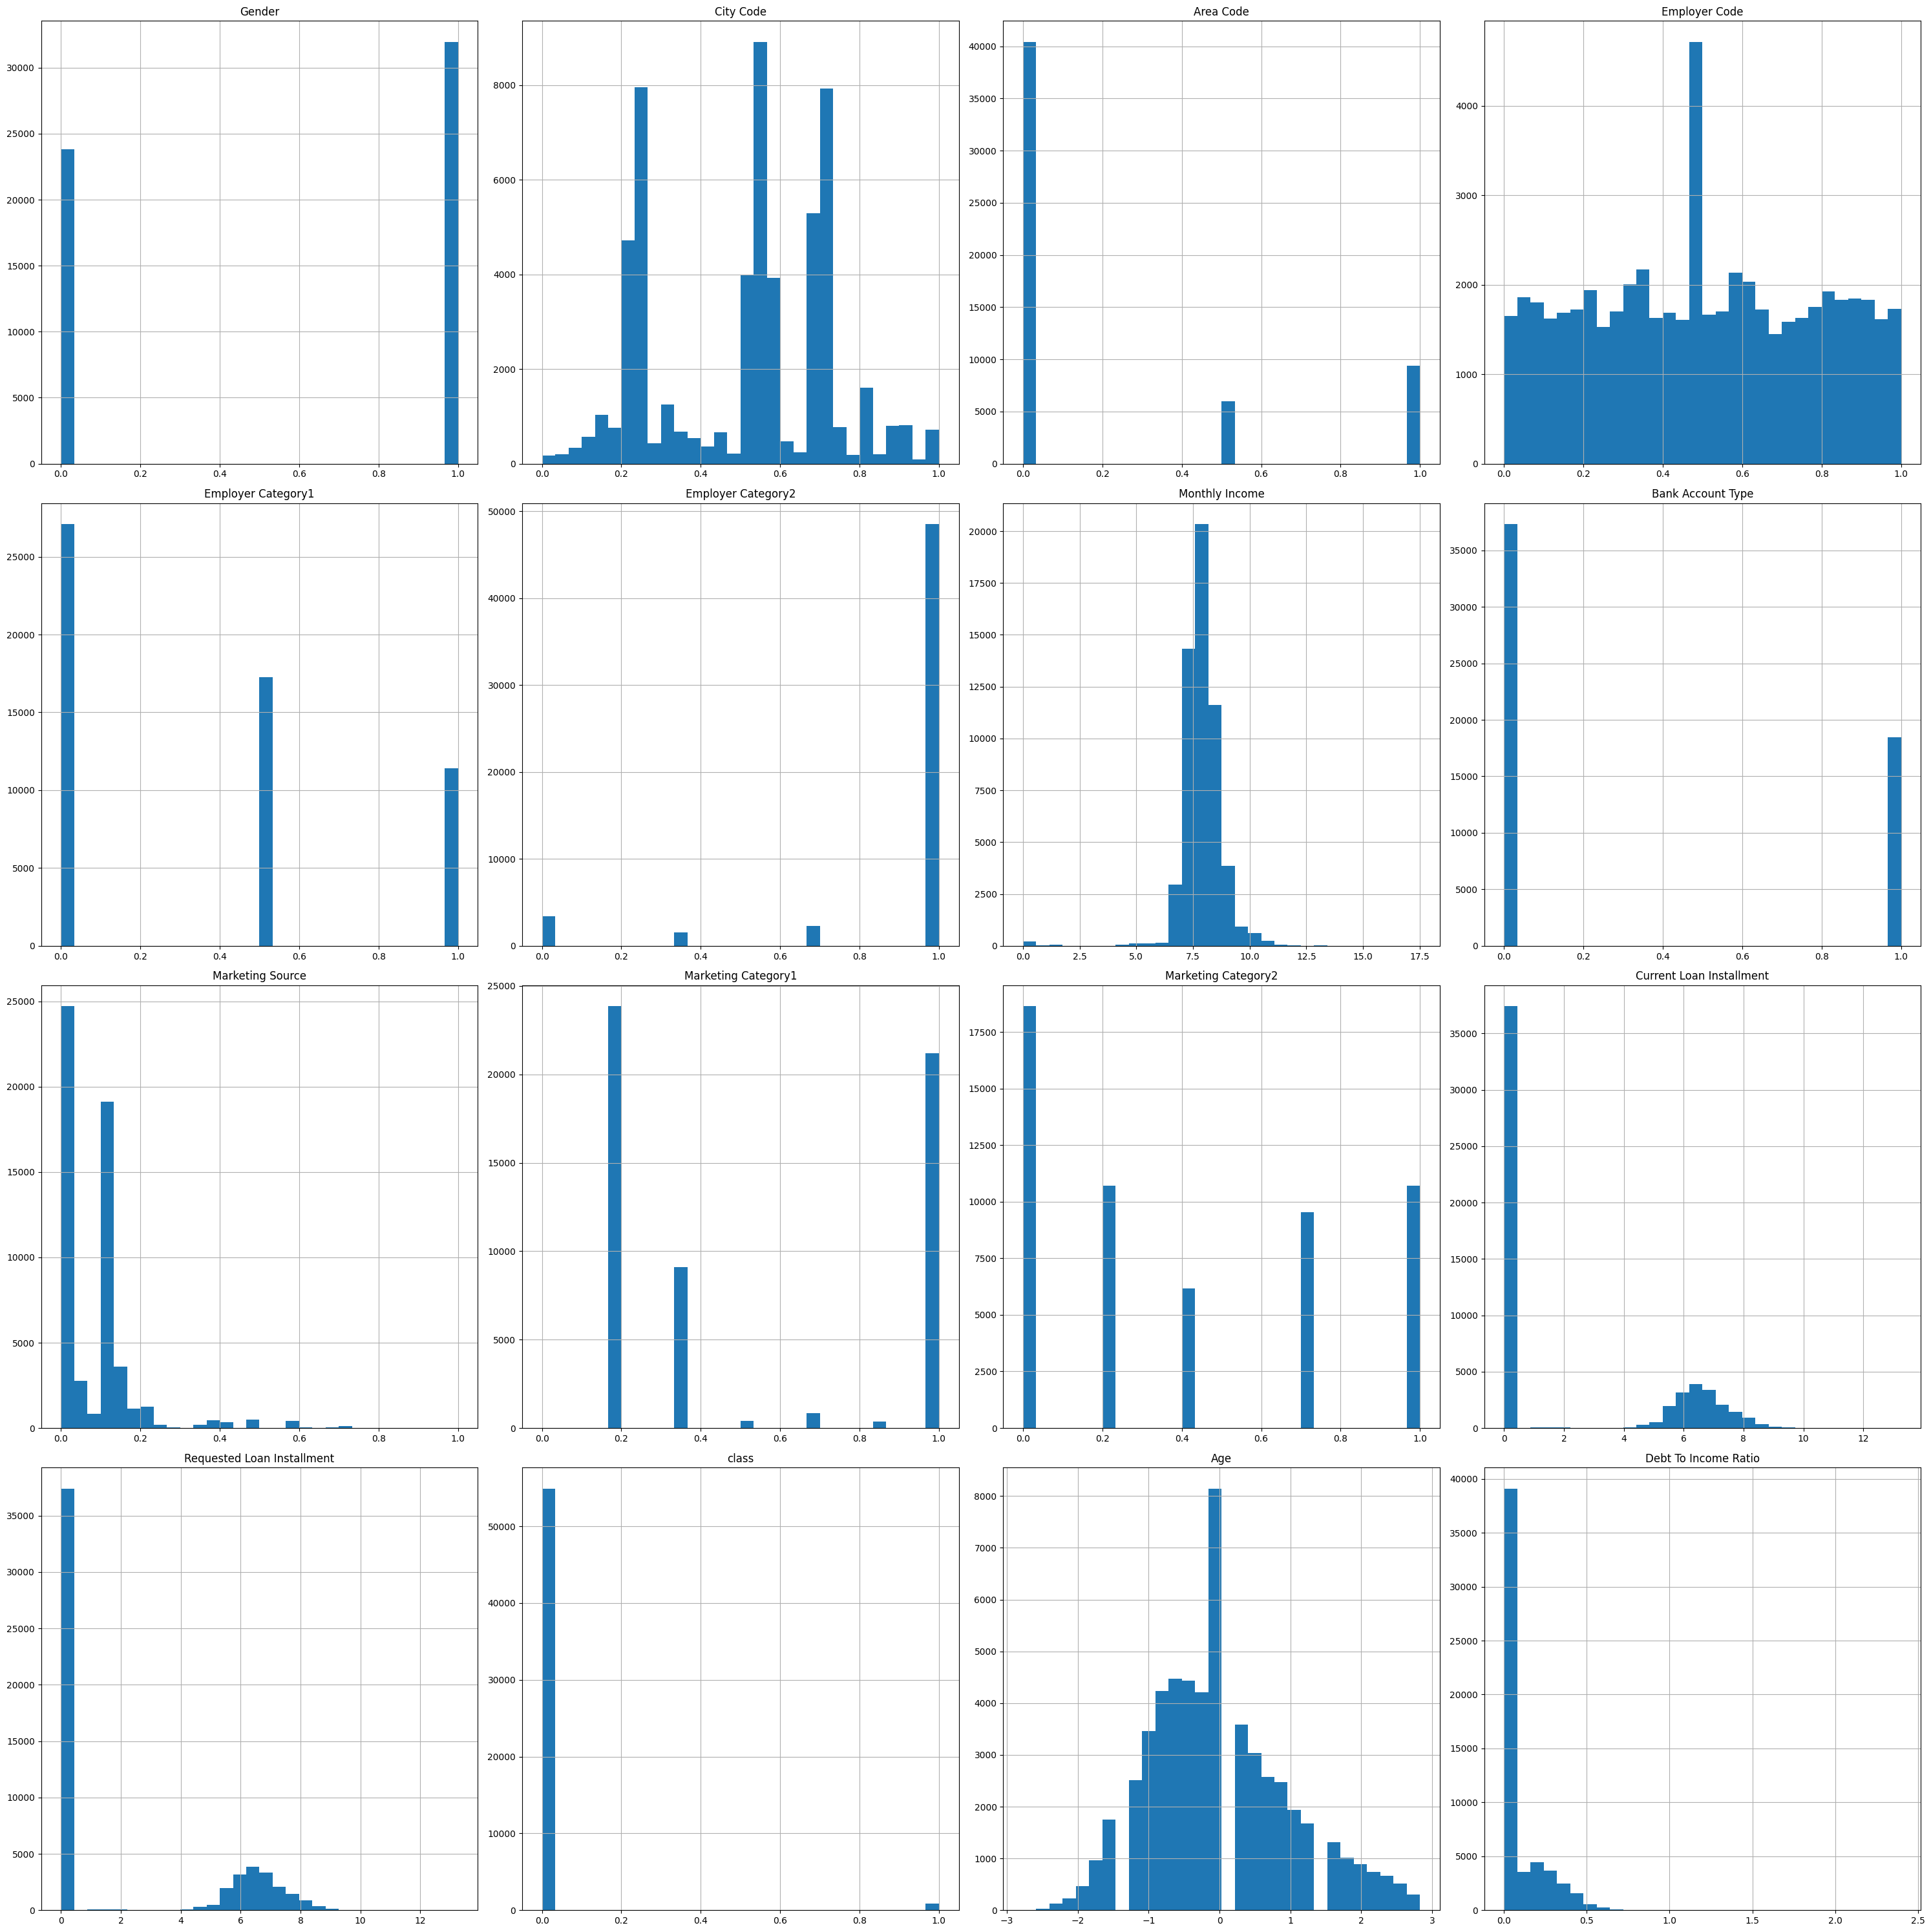

In [49]:
plot_histograms(df_train,df_train.columns)

In [ ]:
# #plot numerical columns
# NUM_COLS = ['Monthly Income', 'Current Loan Installment', 'Requested Loan Amount', 'Loan Repayment Years', 'Interest Rate', 'Requested Loan Installment', 'Age', 'Debt To Income Ratio', 'Monthly Loan Repayment Amount', 'Loan To Income Ratio', 'Payment to Income Ratio']
# plot_histograms(df_train,NUM_COLS)

In [ ]:
# #plot Categorical columns
# CAT_COLS = ['Gender', 'City Code', 'Area Code', 'Employer Code', 'Employer Category1', 'Employer Category2', 'Bank Account Type', 'Marketing Source', 'Marketing Category1', 'Marketing Category2']
# plot_histograms(df_train,CAT_COLS)

# Observations:

### 1. Missing Values:
NUMERICAL:
* Interest Rate: 68.04%  
* Loan Repayment (Years): 39.689742%
* Requested Loan Amount: 39.689742%
* Current Loan Installment: 0.073529%
* Age: 0.014347%

CATEGORICAL:
* Bank Account Type: 13.398494%  
* Employer Category2: 6.140603%
* Employer Category1: 5.726327%
* Area Code: 1.180057%

ACTION:
1. For categorical, i will replace missing values with 'most-frequent' or mode method since the % is not that high.
2. For numerical: ['Interest Rate', 'Loan Repayment (Years)', 'Requested Loan Amount', 'Current Loan Installment'], i will use KNN for better imputation since the % is high and test with remove the columns. Using median or mode will shift the data distribution.
3. For numerical: ['Age'], i will just use simpleimputer with 'median' since the distribution is skwed.

### 2. OUTLIERS:
NUMERICAL(CRITICAL):
* Monthly Income
* Current Loan Installment
* Debt To Income Ratio

OUTLIERS BUT LOGIC:
* Requested Loan Amount: It can be that someone to request for high loan amount
* Interest Rate: It can be that the interest rate is so high

ACTION:  
1. Just apply remove outliers on critical only.
2. Try IQR vs Z-Score (Thresh 3 and 4) -> Z-Score with threshold 3 selected

RESULTS:
1. When using IQR, dataset removed by 20377 rows, with balance:  
After Remove Outliers: class
0: 35024
1: 359

2. When using Z-Score (threshold=3), dataset removed by 986 rows, with balance:  [WIN]  
After Remove Outliers: class
0: 53940
1: 834

3. When using Z-Score (threshold=4), dataset removed by 279 rows, with balance:  
After Remove Outliers: class
0: 54639
1: 842

### 3. SCALING (PENDING FOR TEST)

1. 'Age' scaled using standarization since the data is quite gausian distribute

ACTION:
1. Compare without scaling for ['Monthly Income', 'Current Loan Installment', 'Requested Loan Amount', 'Interest Rate', 'Debt To Income Ratio']
2. RobustScaler for ['Monthly Income', 'Current Loan Installment', 'Requested Loan Amount', 'Interest Rate', 'Debt To Income Ratio']
3. RobustScaler for ['Monthly Income', 'Current Loan Installment', 'Requested Loan Amount']

# Features Correlation

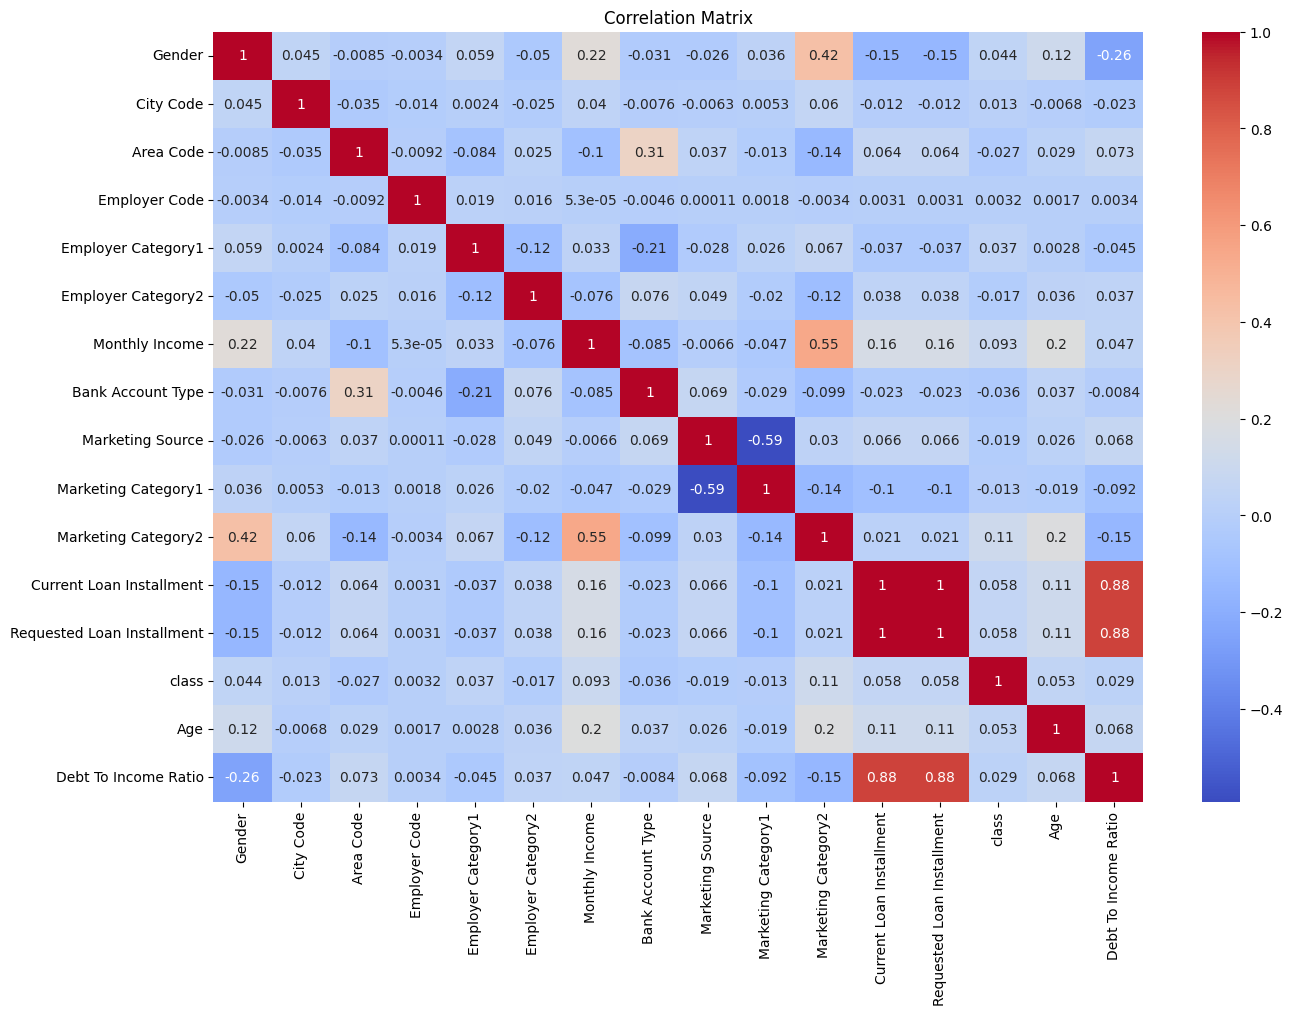

In [50]:
correlation_heatmap(df_train)

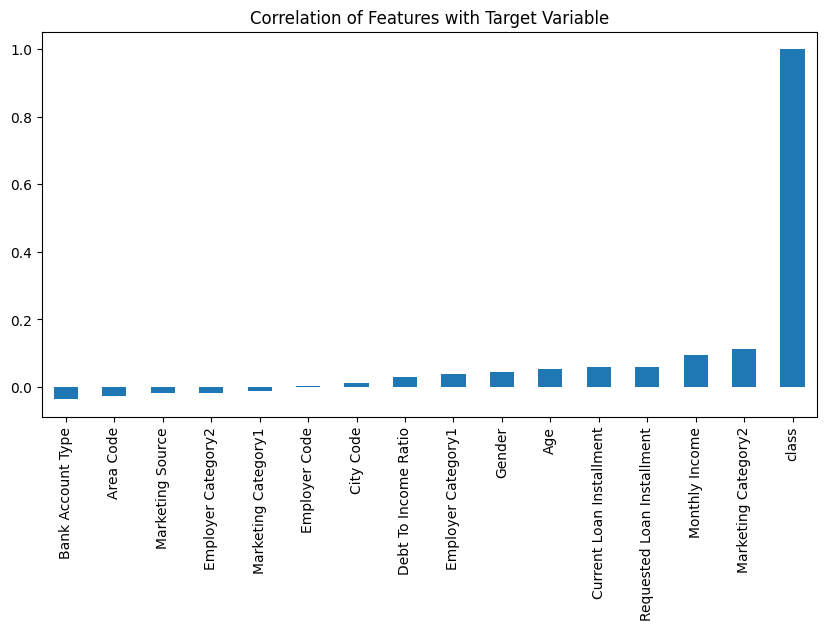

In [51]:
# Let's visualize the correlation of the features with the target variable
plt.figure(figsize=(10,5))
df_train.corr()['class'].sort_values().plot(kind='bar')
plt.title('Correlation of Features with Target Variable')
plt.show()

 # Decide the Performance Metric

 Before building the model, I need to decide the performance metric I would like to optimize towards.

 The most critical performance metric for the rare events modeling is usually the minority class recall or precision values. For example, in the context of fraud detection, I would like to maximize the True Positive Rate (Sensitivity) and capture as many fraud cases as possible. I would like the model NOT to predict Fraud as not-Fraud. False Negative will have a higher cost than False Positive. Hence, I would monitor and optimize RECALL.

 While in context of spam email classification, I would like to minimize the False Positive Rate and not misclassify any important email as spam, so the precision for the minority class is the metric I would like to optimize. False Positive will have a higher cost than False Negative. Hence, I would monitor and optimize PRECISION.

 In this project (loan approval classification), I would like the model NOT to predict approve for unqualified application. False Negative will have a higher cost than False Positive. Hence, I would like a model to have LOW RECALL and optimize PRECISION.

However I would still need to find the best precision-recall values. Therefore I would also look into F2-score since the competition will evaluate from F-beta (=2)

## Handling Imbalance Dataset & Train/Test Split

For imbalance dataset, I will the data-leveling method to test the model performance using:

1. Original imbalance data  
2. RandomUnderSampling  
3. SMOTE  
4. NearMiss Undersampling  
5. NearMiss + SMOTE  

In [52]:
df_train['class'].value_counts()

class
0    54916
1      844
Name: count, dtype: int64

In [53]:
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

In [54]:
def prepare_data_rus_smote_mix(X:pd.DataFrame, y:pd.DataFrame, rus_sampling_strategy:str='auto', smote_sampling_strategy:str='auto', nm_sampling_strategy:str='auto', enable_rus:bool=False, enable_smote:bool=False, enable_nearmiss:bool=False, nm_version:int=3, test_size:float=0.2):
    """
    Prepare data for classification by balancing class distribution through a combination of Random Undersampling (RUS) and Synthetic Minority Oversampling Technique (SMOTE).

    Parameters:
    X (DataFrame): Feature columns of the dataset.
    y (Series): Target column of the dataset.
    rus_sampling_strategy (str): Sampling strategy for RandomUnderSampler. Default is 'auto'.
    smote_sampling_strategy (str): Sampling strategy for SMOTE. Default is 'auto'.
    enable_rus (bool): Flag to enable RandomUnderSampler. Default is True.
    enable_smote (bool): Flag to enable SMOTE. Default is True.
    test_size (float): Ratio of the dataset to include in the test split. Default is 0.2.

    Returns:
    X_train (DataFrame): Training set features.
    X_test (DataFrame): Testing set features.
    y_train (Series): Training set target.
    y_test (Series): Testing set target.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Undersample the majority class on Train dataset only
    if enable_rus:
        rus = RandomUnderSampler(random_state=42, sampling_strategy=rus_sampling_strategy)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    
    if enable_nearmiss:
        # Choose the version of NearMiss to use (NearMiss1, NearMiss2, NearMiss3)
        nm = NearMiss(version=nm_version, sampling_strategy=nm_sampling_strategy)
        X_train, y_train = nm.fit_resample(X_train, y_train)

    if enable_smote:
        smote = SMOTE(random_state=42, sampling_strategy=smote_sampling_strategy)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    # Print class distribution after resampling
    print('After resampling:')
    print('Train set:')
    print(y_train.value_counts())
    print('Test set:')
    print(y_test.value_counts())

    return X_train, X_test, y_train, y_test


# Baseline Model Training

For Imbalance Dataset, there are 3 major techiniques that I can use for model selection:

1. Data Level PreProcessing
2. Cost-Sensitive Learning (Class Weight)
3. Ensemble Method

### Data Level Preprocessing:
There I will compare the base model performance between:

1. Original imbalance data  
2. RandomUnderSampling  
3. SMOTE  
4. NearMiss Undersampling  
5. NearMiss + SMOTE  


### Cost-Sensitive Learning (Class Weight)
Using class_weight='balance' parameters


### Ensemble Method


I will first check the model performance using imbalanced data directly. A model without oversampling or under-sampling will gives me a baseline to compare the model performance. I will just use Random Forest model as baseline modelling

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [56]:
# Generalize classifier training
def train_classifier(classifier:str, X_train:pd.DataFrame, y_train:pd.DataFrame, X_test:pd.DataFrame, y_test:pd.DataFrame):
    """
    Train a classifier, evaluate it, and return evaluation metrics.

    Parameters:
        classifier: Classifier object (e.g., sklearn classifier).
        X_train: Training features DataFrame.
        y_train: Training target variable DataFrame.
        X_test: Testing features DataFrame.
        y_test: Testing target variable DataFrame.

    Returns:
        y_pred: Predicted labels on the test set.
        metrics: Dictionary containing evaluation metrics.
    """
    classifier.fit(X_train, y_train)

    # Calculating training accuracy
    train_accuracy = classifier.score(X_train, y_train)
    print(f"Training Accuracy: {train_accuracy}")

    # Calculate test accuracy
    y_pred = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy}")

    # Additional evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    fbeta = fbeta_score(y_test, y_pred, beta=0.5)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    confusion = confusion_matrix(y_test, y_pred)

    # Construct metrics dictionary
    metrics = {
        'Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'F2 Score': f2,
        'Fbeta Score': fbeta,
        'Specificity': specificity,
        'Confusion Matrix': confusion
    }

    print(classification_report(y_test, y_pred))

    return y_pred, metrics

# 1. DATA-LEVEL PREPROCESSING METHOD

In [57]:
# Separate features and target variable
X = df_train.drop('class', axis=1)
y = df_train['class']

## BASELINE: Random Forest Classifier: WITHOUT OVER/UNDERSAMPLING

In [58]:
X_train, X_test, y_train, y_test = prepare_data_rus_smote_mix(X, y, rus_sampling_strategy=0.2, 
                                                              smote_sampling_strategy=0.75,
                                                              nm_sampling_strategy='auto',
                                                              enable_rus=False,
                                                              enable_smote=False,
                                                              enable_nearmiss=False,
                                                              nm_version=3,
                                                              test_size=0.25)

After resampling:
Train set:
class
0    41187
1      633
Name: count, dtype: int64
Test set:
class
0    13729
1      211
Name: count, dtype: int64


In [59]:
from sklearn.ensemble import RandomForestClassifier

# rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=8, random_state=0)
rfc_baseline = RandomForestClassifier()
rfc_baseline_pred, rfc_baseline_metrics = train_classifier(rfc_baseline, X_train, y_train, X_test, y_test)

for metric, value in rfc_baseline_metrics.items():
    print(f"{metric}: {value}")

Training Accuracy: 0.9996652319464371
Test Accuracy: 0.9846484935437589
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13729
           1       0.20      0.00      0.01       211

    accuracy                           0.98     13940
   macro avg       0.59      0.50      0.50     13940
weighted avg       0.97      0.98      0.98     13940

Accuracy: 0.9846484935437589
Precision: 0.2
Recall: 0.004739336492890996
F1 Score: 0.00925925925925926
F2 Score: 0.005889281507656065
Fbeta Score: 0.021645021645021644
Specificity: 0.9997086459319688
Confusion Matrix: [[13725     4]
 [  210     1]]


## Random Forest Classifier: SMOTE OVERSAMPLING

In [60]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = prepare_data_rus_smote_mix(X, y, rus_sampling_strategy=0.2, 
                                                              smote_sampling_strategy='auto',
                                                              nm_sampling_strategy='auto',
                                                              enable_rus=False,
                                                              enable_smote=True,
                                                              enable_nearmiss=False,
                                                              nm_version=3,
                                                              test_size=0.2)

After resampling:
Train set:
class
0    43933
1    43933
Name: count, dtype: int64
Test set:
class
0    10983
1      169
Name: count, dtype: int64


In [61]:
rfc_smote = RandomForestClassifier()
rfc_smote_pred, rfc_smote_metrics = train_classifier(rfc_smote, X_train_smote, y_train_smote, X_test_smote, y_test_smote)

for metric, value in rfc_smote_metrics.items():
    print(f"{metric}: {value}")

Training Accuracy: 0.9998748093688116
Test Accuracy: 0.9810796269727403
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10983
           1       0.10      0.03      0.05       169

    accuracy                           0.98     11152
   macro avg       0.54      0.51      0.52     11152
weighted avg       0.97      0.98      0.98     11152

Accuracy: 0.9810796269727403
Precision: 0.09615384615384616
Recall: 0.029585798816568046
F1 Score: 0.04524886877828054
F2 Score: 0.03434065934065934
Fbeta Score: 0.06631299734748011
Specificity: 0.9957206592005827
Confusion Matrix: [[10936    47]
 [  164     5]]


## Random Forest Classifier: RANDOM UNDERSAMPLING (RUS)

In [62]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = prepare_data_rus_smote_mix(X, y, rus_sampling_strategy='auto', 
                                                              smote_sampling_strategy=1,
                                                              nm_sampling_strategy='auto',
                                                              enable_rus=True,
                                                              enable_smote=False,
                                                              enable_nearmiss=False,
                                                              nm_version=3,
                                                              test_size=0.2)

After resampling:
Train set:
class
0    675
1    675
Name: count, dtype: int64
Test set:
class
0    10983
1      169
Name: count, dtype: int64


In [63]:
rfc_rus = RandomForestClassifier()
rfc_rus_pred, rfc_rus_metrics = train_classifier(rfc_rus, X_train_rus, y_train_rus, X_test_rus, y_test_rus)

for metric, value in rfc_rus_metrics.items():
    print(f"{metric}: {value}")

Training Accuracy: 0.9985185185185185
Test Accuracy: 0.7071377331420373
              precision    recall  f1-score   support

           0       1.00      0.70      0.83     10983
           1       0.04      0.86      0.08       169

    accuracy                           0.71     11152
   macro avg       0.52      0.78      0.45     11152
weighted avg       0.98      0.71      0.81     11152

Accuracy: 0.7071377331420373
Precision: 0.04281074697372306
Recall: 0.8579881656804734
F1 Score: 0.08155230596175478
F2 Score: 0.1784395766674871
Fbeta Score: 0.052854122621564484
Specificity: 0.7048165346444505
Confusion Matrix: [[7741 3242]
 [  24  145]]


## Random Forest Classifier: NearMiss UNDERSAMPLING 

In [64]:
X_train_nm, X_test_nm, y_train_nm, y_test_nm = prepare_data_rus_smote_mix(X, y, rus_sampling_strategy='auto', 
                                                              smote_sampling_strategy=1,
                                                              nm_sampling_strategy='auto',
                                                              enable_rus=False,
                                                              enable_smote=False,
                                                              enable_nearmiss=True,
                                                              nm_version=3,
                                                              test_size=0.2)

After resampling:
Train set:
class
0    675
1    675
Name: count, dtype: int64
Test set:
class
0    10983
1      169
Name: count, dtype: int64


In [65]:
rfc_nm = RandomForestClassifier()
rfc_nm_pred, rfc_nm_metrics = train_classifier(rfc_nm, X_train_nm, y_train_nm, X_test_nm, y_test_nm)

for metric, value in rfc_nm_metrics.items():
    print(f"{metric}: {value}")

Training Accuracy: 0.9992592592592593
Test Accuracy: 0.5537123385939742
              precision    recall  f1-score   support

           0       0.99      0.55      0.71     10983
           1       0.02      0.62      0.04       169

    accuracy                           0.55     11152
   macro avg       0.51      0.59      0.37     11152
weighted avg       0.97      0.55      0.70     11152

Accuracy: 0.5537123385939742
Precision: 0.02092467118373854
Recall: 0.621301775147929
F1 Score: 0.04048582995951417
F2 Score: 0.09220231822971549
Fbeta Score: 0.02593745368311842
Specificity: 0.5526723117545297
Confusion Matrix: [[6070 4913]
 [  64  105]]


1. In general nm=version 3 gives the best eval metrics compare to version 1 or 2.
2. Compare NearMiss VS RUS:
    * Accuracy: RUS
    * Precision: RUS
    * Recall: RUS
    * f2-score: RUS

In undersampling RUS is better in undersampling compare to NearMiss

## Random Forest Classifier: RUS + SMOTE

In [76]:
X_train_rus_smote, X_test_rus_smote, y_train_rus_smote, y_test_rus_smote = prepare_data_rus_smote_mix(X, y, rus_sampling_strategy=0.1, 
                                                              smote_sampling_strategy=0.3,
                                                              nm_sampling_strategy='auto',
                                                              enable_rus=True,
                                                              enable_smote=True,
                                                              enable_nearmiss=False,
                                                              nm_version=3,
                                                              test_size=0.2)

After resampling:
Train set:
class
0    6750
1    2025
Name: count, dtype: int64
Test set:
class
0    10983
1      169
Name: count, dtype: int64


In [77]:
rfc_rus_smote = RandomForestClassifier()
rfc_rus_smote_pred, rfc_rus_smote_metrics = train_classifier(rfc_rus_smote, X_train_rus_smote, y_train_rus_smote, X_test_rus_smote, y_test_rus_smote)

for metric, value in rfc_rus_smote_metrics.items():
    print(f"{metric}: {value}")

Training Accuracy: 0.9994301994301994
Test Accuracy: 0.9649390243902439
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10983
           1       0.10      0.16      0.12       169

    accuracy                           0.96     11152
   macro avg       0.54      0.57      0.55     11152
weighted avg       0.97      0.96      0.97     11152

Accuracy: 0.9649390243902439
Precision: 0.09782608695652174
Recall: 0.15976331360946747
F1 Score: 0.12134831460674157
F2 Score: 0.14180672268907563
Fbeta Score: 0.10604870384917517
Specificity: 0.9773285987435127
Confusion Matrix: [[10734   249]
 [  142    27]]


# Observation:

1. NearMiss Undersampling (version3) give the better metrics. 
2. For Undersampling, RUS gives better metrics compare with NearMiss. 
2. Combination of RUS and SMOTE also give better precision and f2-score. However, I might need to find the best combination ratio strategy of this method.

# 2. COST-SENSITIVE LEARNING METHOD

#### IMPORTANT!!!  
If you're using cost-sensitive learning techniques, it's generally recommended to train the models on the original imbalanced dataset rather than on a dataset generated using SMOTE or other oversampling techniques. This is because cost-sensitive learning methods implicitly account for class imbalance by adjusting the misclassification costs, and oversampling techniques like SMOTE can potentially introduce bias into the model by altering the class distribution.

## Random Forest Classifier: CLASS-WEIGHT

class_weight='balanced' -> automatically adjusts the class weights inversely proportional to class frequencies in the input data. This means that the minority class will have higher weights compared to the majority class.

In [ ]:
# rfc_rus_smote_cw = RandomForestClassifier(class_weight='balanced', random_state=42)
# rfc_rus_smote_cw_pred, rfc_rus_smote_cw_metrics = train_classifier(rfc_rus_smote_cw, X_train, y_train, X_test, y_test)

# for metric, value in rfc_rus_smote_cw_metrics.items():
#     print(f"{metric}: {value}")

With class-weight implementation, there is no much differrence with without using it. I can reject this method!

# 3. ENSEMBLE LEARNING + BAGGING CLASSIFIER METHOD
Algorithms: Random Forest, BaggingClassifier  
Description: Train multiple base models (e.g., decision trees) on different subsets of the dataset, then combine their predictions through averaging (for regression) or voting (for classification).  
Advantage: Helps reduce overfitting and variance, and can improve model performance on imbalanced datasets.  

## BaggingClassifier on RUS + SMOTE Dataset

In [79]:
# from sklearn.ensemble import BaggingClassifier

In [80]:
# rfc_rus_smote_bag = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=10, random_state=0)
# rfc_rus_smote_bag_pred, rfc_rus_smote_bag_metrics = train_classifier(rfc_rus_smote_bag, X_train_rus_smote, y_train_rus_smote, X_test_rus_smote, y_test_rus_smote)

# for metric, value in rfc_rus_smote_bag_metrics.items():
#     print(f"{metric}: {value}")

Training Accuracy: 0.9852991452991453
Test Accuracy: 0.9624282639885222
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10983
           1       0.09      0.16      0.11       169

    accuracy                           0.96     11152
   macro avg       0.54      0.57      0.55     11152
weighted avg       0.97      0.96      0.97     11152

Accuracy: 0.9624282639885222
Precision: 0.08881578947368421
Recall: 0.15976331360946747
F1 Score: 0.11416490486257928
F2 Score: 0.1377551020408163
Fbeta Score: 0.09747292418772563
Specificity: 0.9747792042247109
Confusion Matrix: [[10706   277]
 [  142    27]]


## DISCOVERY:

* With BaggingClassifier, reduce the test accuracy but increase in precision, recall and f2-score
* Need to find the suitable n_estimators

# 4. CROSS VALIDATION (PENDING)

## Random Forest Classifier: NearMiss UNDERSAMPLING + CV=5 -KIV

In [ ]:
# rfc_nm_cv = RandomForestClassifier()
# # rfc_nm_cv_pred, rfc_nm_cv_metrics = train_classifier(rfc_nm_cv, X_train_nm, y_train_nm, X_test_nm, y_test_nm, enable_cv=True)

# mean_score = train_cv_model(rfc_nm_cv, X_train_nm, y_train_nm)
# # Print the mean score obtained from cross-validation
# print("Mean Cross-validation Score:", mean_score)

### RESULTS:

Upon experimenting the baseline model with various method, I can conclude that:

1. NearMiss Undersampling with (version 3) give the best eval metric compare to others.  
2. MIX method between RUS + SMOTE is the best eval metric. However, multiple experimentation need to be done to find the best sampling_strategy ratio! (currently use rus_sampling=0.1, smote_sampling='auto')
3. SMOTE only is not the best option, although it generate more dataset.
4. Using Cost-Sensitive Learning does not improve the model performance.
5. Using Ensemble BaggingClassifier does improve the model performance.

### SELECTED METHOD
* RUS + SMOTE with Ensemble BaggingClassifier.

### IMPROVEMENT
* Can try different Ensemble Techniques

# FIND THE BEST MODEL ALGORITHM

Since i already know for imbalance dataset, dataset handling using RUS + SMOTE gives the best recall eval metric, now i will try to train the model with others tree-based algorithm.

In [81]:
# Set the best Test/Train dataset based on aboved experiment
X_train, X_test, y_train, y_test = X_train_rus_smote, X_test_rus_smote, y_train_rus_smote, y_test_rus_smote

## 2. GradientBoost

In [82]:
from sklearn.ensemble import GradientBoostingClassifier

In [83]:
grad_boost = GradientBoostingClassifier(random_state=42)

In [84]:
grad_boost_pred, grad_boost_metrics = train_classifier(grad_boost, X_train, y_train, X_test, y_test)

for metric, value in grad_boost_metrics.items():
    print(f"{metric}: {value}")

Training Accuracy: 0.9094017094017094
Test Accuracy: 0.9674497847919655
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10983
           1       0.11      0.17      0.13       169

    accuracy                           0.97     11152
   macro avg       0.55      0.57      0.56     11152
weighted avg       0.97      0.97      0.97     11152

Accuracy: 0.9674497847919655
Precision: 0.112
Recall: 0.16568047337278108
F1 Score: 0.1336515513126492
F2 Score: 0.15118790496760262
Fbeta Score: 0.11976047904191618
Specificity: 0.9797869434580716
Confusion Matrix: [[10761   222]
 [  141    28]]


## 3. XGBoost

In [85]:
import xgboost as xgb
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
xgb = XGBClassifier(random_state=42)

In [ ]:
xgb_pred, xgb_metrics = train_classifier(xgb, X_train, y_train, X_test, y_test)

for metric, value in xgb_metrics.items():
    print(f"{metric}: {value}")

## 4. CatBoost

In [ ]:
from catboost import CatBoostClassifier

# Initialize CatBoost classifier
# catboost = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=False)
catboost = CatBoostClassifier(verbose=False)

In [ ]:
catboost_pred, catboost_metrics = train_classifier(catboost, X_train, y_train, X_test, y_test)

for metric, value in catboost_metrics.items():
    print(f"{metric}: {value}")

## 6. Ensemble Model


In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble_classifiers = [rfc_rus_smote, grad_boost, xgb, catboost]
ensemble_classifier_names = ['Random Forest', 'GradientBoost', 'XGBoost', 'Catboost']

In [ ]:
# Create a list of tuples with classifier names and classifiers
estimators = list(zip(ensemble_classifier_names, ensemble_classifiers))

# Define the ensemble classifier using VotingClassifier
# ensemble_classifier = VotingClassifier(estimators=[('rf', rf_classifier), ('gb', gb_classifier)], voting='hard')
ensemble = VotingClassifier(estimators=estimators, voting='hard')

In [ ]:
ensemble_pred, ensemble_metrics = train_classifier(ensemble, X_train, y_train, X_test, y_test)

for metric, value in ensemble_metrics.items():
    print(f"{metric}: {value}")

# MODEL EVALUATION

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# classifiers = [rfc, grad_boost, xgb, catboost, ens]
classifier_names = ['Random Forest', 'GradientBoost', 'XGBoost', 'Catboost', 'EnsembleModel']
y_preds = [rfc_rus_smote_pred, grad_boost_pred, xgb_pred, catboost_pred, ensemble_pred]

### Confusion Matrix

In [ ]:
def plot_confusion_matrices(y_test:pd.DataFrame, y_preds:pd.DataFrame, classifier_names:list[str]) -> None:
    """
    Plots the confusion matrices of multiple models in a single plot.

    Parameters:
        y_test: Testing set targets for all classifiers
        y_preds: List of predicted target values for each classifier
        model_names: List of model names

    Returns:
        None
    """
    n_models = len(classifier_names)
    n_rows = (n_models + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 6 * n_rows))

    for ax, y_pred, model_name in zip(axes.flatten(), y_preds, classifier_names):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'{model_name}: Confusion Matrix')

    if n_models % 2 != 0:
        fig.delaxes(axes[-1, -1])  # Remove empty subplot if odd number of models

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_test, y_preds, classifier_names)

### Accuracy

In [ ]:
for classifier_name, y_pred in zip(classifier_names, y_preds):
    accuracy = accuracy_score(y_test, y_pred)    
    print(f'Accuracy for {classifier_name}: {accuracy}')

### Recall

In [ ]:
for classifier_name, y_pred in zip(classifier_names, y_preds):
    recall = recall_score(y_test, y_pred)    
    print(f'Recall for {classifier_name}: {recall}')

### Precision

In [ ]:
for classifier_name, y_pred in zip(classifier_names, y_preds):
    precision = precision_score(y_test, y_pred)   
    print(f'Precision for {classifier_name}: {precision}')

### Fbeta-Score

The Fbeta-Scores is a generalization of the F1 score that allows you to control the balance between precision and recall by using a paramete.  

* β=1, it's equivalent to the F1 score, which balances precision and recall equally.

* β>1, it gives more weight to recall, which can be useful when recall is more important than precision. For example, in tasks where it's crucial to capture as many relevant instances as possible, such as detecting diseases in medical diagnosis.

* β<1, it gives more weight to precision, which can be useful when precision is more important than recall. For example, in tasks where reducing false positives is critical, such as spam email detection.

In [ ]:
for classifier_name, y_pred in zip(classifier_names, y_preds):
    f2 = fbeta_score(y_test, y_pred, beta=0.5)  
    print(f'Fbeta-score for {classifier_name}: {f2}')

### Specificity

In [ ]:
# Calculate specificity for each model
for classifier_name, y_pred in zip(classifier_names, y_preds):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    print(f'Specificity for {classifier_name}: {specificity}')

### Precision-Recall Curves

In [ ]:
def plot_precision_recall_curve(y_test:pd.DataFrame, y_preds:pd.DataFrame, classifier_names:list[str]) -> None:
    """
    Plots the Precision-Recall curve of multiple models in a single plot.

    Parameters:
        y_test: Test dataset
        y_preds: List of predicted target values for each classifier
        model_names: List of model names

    Returns:
        None
    """
    plt.figure(figsize=(10, 8))

    for classifier_name, y_pred in zip(classifier_names, y_preds):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        plt.plot(recall, precision, label=classifier_name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Multiple Classifiers')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_curve(y_test, y_preds, classifier_names)


## ROC Curves

In [ ]:
def plot_multi_roc_curve(y_test:pd.DataFrame, y_preds:pd.DataFrame, classifier_names:list[str]) -> None:
    """
    Plots the ROC curve of multiple models in a single plot.

    Parameters:
        y_test: Test dataset
        y_preds: List of predicted target values for each classifier
        model_names: List of model names

    Returns:
        None
    """
    plt.figure(figsize=(10, 8))
    for y_pred, classifier_names in zip(y_preds, classifier_names):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (classifier_names, roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_multi_roc_curve(y_test, y_preds, classifier_names)


## Feature Importance

In [ ]:
tree_classifiers = [rfc_rus_smote, grad_boost, xgb, catboost]
tree_classifier_names = ['Random Forest', 'GradientBoost', 'XGBoost', 'Catboost']

In [ ]:
def plot_feature_importance(classifier, X_train, ax, title):
    feature_importance = pd.DataFrame(classifier.feature_importances_, index=X_train.columns, columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)
    sns.barplot(y=feature_importance.index, x=feature_importance['Feature Importance'], ax=ax).set_title(title)
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Features')
    ax.tick_params(axis='x', rotation=90)

# Calculate the number of required subplots
num_classifiers = len(tree_classifiers)

# Calculate the number of rows and columns for subplots
num_rows = (num_classifiers + 1) // 2  # Adding 1 before division to handle odd number of classifiers
num_cols = 2

# Create subplots
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 15))
fig.subplots_adjust(wspace=0.5)

# Now, iterate over your classifiers and corresponding names
for classifier, classifier_name, subplot in zip(tree_classifiers, tree_classifier_names, ax.flatten()):
    plot_feature_importance(classifier, X_train, subplot, classifier_name)

# Hide any unused subplots
for i in range(num_classifiers, num_rows * num_cols):
    fig.delaxes(ax.flatten()[i])

plt.show()

# MODEL SELECTION:

1. I will select Random Forest since it gives the highest f-beta score and precision compare to others.
2. I will implement BaggingClassifier also to improve the model performance.

## Model Fine-Tuning

NOTE: Finding best hyperparameter will take some time to run

In [ ]:
# from sklearn.metrics import make_scorer, fbeta_score
# from sklearn.model_selection import GridSearchCV

In [ ]:
# def tune_hyperparameters(classifier:str, param_grid:dict, X_train:pd.DataFrame, y_train:pd.DataFrame, X_test:pd.DataFrame, y_test:pd.DataFrame):
#     """
#     Use GridSearchCV to fine tune hyperparameters of classifiers.

#     Parameters:
#         classifier: classifier object from sklearn only
#         param_grid: dictionary of hyperparameters to tune
#         X_train: training set features
#         X_test: testing set features
#         y_train: training set target
#         y_test: testing set target

#     Returns:
#         grid_search.best_estimator_: best model from the hyperparameter tuning
#     """

#     # grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='roc_auc')
#     grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring = 'f1', n_jobs = -1, verbose = 2)
#     grid_search.fit(X_train, y_train)
#     print('Best parameters:', grid_search.best_params_)

#     print('Best score:', grid_search.best_score_)

#     # Evaluate the best model
#     y_pred = grid_search.predict(X_test)

#     print('Classification Report:')
#     print(classification_report(y_test, y_pred))

#     return grid_search.best_estimator_, y_pred

In [ ]:
# def find_best_hyperparameters (model:str, param_grid:dict, X_train:pd.DataFrame, y_train:pd.DataFrame, cv:int=5):
#     """
#     Find the best hyperparameters for a given model using GridSearchCV.

#     Parameters:
#         model: A scikit-learn estimator object.
#         param_grid (dict): The parameter grid to search over.
#         X (array-like): The feature matrix.
#         y (array-like): The target vector.
#         cv (int or cross-validation generator, optional): Determines the cross-validation strategy.

#     Returns:
#         dict: The best hyperparameters found by GridSearchCV.
#     """

#     # Define your custom scoring function for F_beta score with beta=0.5
#     scorer = make_scorer(fbeta_score, beta=0.5) 
    
#     # grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='roc_auc')
#     grid_search = GridSearchCV(model, param_grid, cv=cv, scoring = scorer, n_jobs = -1, verbose = 2)
#     grid_search.fit(X_train, y_train)

#     print('Best parameters:', grid_search.best_params_)
#     print("Best score found: {:.4f}".format(grid_search.best_score_))

#     return grid_search.best_params_

## BEST Random Forest

In [ ]:
# # Define the parameter grid for Random Forest
# rfc_params = {
#     'n_estimators': [100, 200, 300], 
#     'max_depth': [None, 10, 20], 
#     'min_samples_split': [2, 5, 10], 
#     'min_samples_leaf': [1, 2, 4], 
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False],
#     'class_weight': [None, 'balanced']
# }

# rfc = RandomForestClassifier()
# best_rfc_parameters = find_best_hyperparameters(rfc, rfc_params, X_train_rus_smote, y_train_rus_smote)


Time taken: 7mins 45sec
Best parameters: {'bootstrap': False, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best score found: 0.9544

In [ ]:
# rfc_params = {
#     'n_estimators': 300, 
#     'max_depth': None, 
#     'min_samples_split': 2, 
#     'min_samples_leaf': 1, 
#     'max_features': 'sqrt',
#     'bootstrap': False,
#     'class_weight': None
# }

In [ ]:
# best_rfc_rus_smote = RandomForestClassifier(**rfc_params)
# best_rfc_rus_smote_pred, best_rfc_rus_smote_metrics = train_classifier(best_rfc_rus_smote, X_train_rus_smote, y_train_rus_smote, X_test_rus_smote, y_test_rus_smote)

# for metric, value in best_rfc_rus_smote_metrics.items():
#     print(f"{metric}: {value}")

### Implement BaggingClassifier to the Fine-Tune Model

In [ ]:
# best_rfc_rus_smote_bag = BaggingClassifier(estimator=best_rfc_rus_smote, n_estimators=10, random_state=0)
# best_rfc_rus_smote_bag_pred, best_rfc_rus_smote_bag_metrics = train_classifier(best_rfc_rus_smote_bag, X_train_rus_smote, y_train_rus_smote, X_test_rus_smote, y_test_rus_smote)

# for metric, value in best_rfc_rus_smote_bag_metrics.items():
#     print(f"{metric}: {value}")

## Submission

In [ ]:
df_test = data_preprocessing('../data/test.csv', is_submission=True)

In [ ]:
def save_submission(model, df_test:pd.DataFrame, output_path:str):
    """
    Creates the predictions.csv file for submission to the kaggle competition.

    Parameters:
        model: trained classifier object

    Returns:
        predictions.csv: csv file of the predictions
    """
    # make predictions and append to the dataframe
    y_pred = model.predict(df_test)

    submit = pd.read_csv('../data/sample_submission.csv')
    submit['class'] = np.round(y_pred).astype(int)
    
    return submit.to_csv(output_path, index=False) 

In [ ]:
BEST_MODEL = xgb
OUTPUT_PATH = '../submission/tree-based/submission_17.csv'

save_submission(BEST_MODEL, df_test, OUTPUT_PATH)

In [ ]:
df_submit = pd.read_csv(OUTPUT_PATH)
df_submit['class'].value_counts()

# PERSONAL VIEW

In [ ]:
desc_train = summary_df(df_train)
desc_train.style.background_gradient()

In [ ]:
desc_test = summary_df(df_test)
desc_test.style.background_gradient()

### Observation:
Problems 1:  
* Monthly Income: df_train max monthly is 3.05 but in test 2135!  
* Reasons: Might have accidently remove too much outliers since i use IQR method.  
* Action: Can try to remove outliers using Z-Score (thresh 3.5) instead. OR do not implement remove outliers.  

Problem 2:
* Current Loan Installment: test data set is 52 but in train just 8.6?  
* Reasons: Might have accidently remove too much outliers since i use Z-score (thresh=3) method.  
* Action: Can try to remove outliers using Z-Score (thresh 3.5) instead. OR do not implement remove outliers.

Using Z-score Thresh 3.5 give better fbeta compare to totally remove outliers

## Improvement Plan

[/] Try remove outliers without scaling since when scaling the scale for train and real world data (test.csv) might be different.  
Result: Scaling is better. So i use robustscaling

[x] Try use bins for numerial cat  
Result:  

[/] Try different Scaling Method (Standarization vs RobustScaler), Normalization not suitable  
Result: RobustScaler is better  

[x] Try remove outliers - scale - impute  

[x] Try: remove outliers - impute - scale  

[/] Handle Outliers using Z-score (thresh 3 and 4)
Result: Using Thresh 4 only remove 2 rows, Using thresh 3 remove 900 rows  

[/] Handle Outliers using IQR vs Z-score  
Result: IQR method will remove about 27k rows. So i combine the method for handling outliers with IQR for "Monthly Income" and Z-Score for others.  

[/] Test different RUS/SMOTE ratio  
Result: rus_sampling_strategy=0.1, smote_sampling_strategy='auto'. Need to try more.

[/] Use Ensemble method to ensemble models  
Result: Using BaggingClassifier give better eval metrics compare to custom Ensemble with voting='hard' config.


[x] Undersampling multiple train dataset, train with different model then use ensemble all models  


[x] Traing using ANN

[x] Try to find the max value for monthly income, loan amount, current loan amount, where the approval is approved. Hard coded to return 0, train for model with below outliers.   
Programming + AI